In [10]:
#%%

import numpy as np
import pandas as pd
from sympy import im 
import torch 
import torch.nn 
import matplotlib.pyplot as plt
from pd.nn.model import MLP

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *
from pd.data.scaler import get_scaler



In [3]:
train_data = pd.read_parquet(DATADIR+"train_data.parquet")
train_labels = pd.read_csv(DATADIR+"train_labels.csv")
cont_cols = [col for col in train_data.columns.to_list() if col not in CATCOLS + ["customer_ID", "S_2", "target"]]


In [4]:
train_customers = train_data.customer_ID


In [5]:
train_customer_indices = train_customers.reset_index().set_index("customer_ID").groupby('customer_ID').apply(lambda x : x.to_numpy().reshape(-1, )).to_dict()



In [6]:
train_customer_indices

{'0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),
 '00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5': array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64),
 '00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], dtype=int64),
 '000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc': array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], dtype=int64),
 '00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed': array([52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=int64),
 '000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c': array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77], dtype=int64),
 '000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4': array([78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90], dtype=int64),

In [7]:
c1 = train_labels[train_labels.target==1]
c1d = train_data[train_data.customer_ID.isin(c1.customer_ID)]

In [8]:
c0d = train_data[~train_data.customer_ID.isin(c1.customer_ID)]

In [10]:
train_data[train_data.customer_ID == train_labels[train_labels.target==1].iloc[0].customer_ID]

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,0.400025,0,0.954861,0.023890,0.003140,NaN,0.0,1.175081,...,-1,-1,-1,1,0,0.870115,0.141214,1,0.008945,8
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,0.405788,0,0.944042,0.025613,0.008950,NaN,0.0,1.177973,...,-1,-1,-1,1,0,0.864712,0.145885,1,0.002125,8
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,0.403615,1,0.940261,0.026016,0.009074,NaN,0.0,1.175785,...,-1,-1,-1,1,0,0.871729,0.144555,1,0.000765,8
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,0.391495,1,0.936253,0.029538,0.005778,NaN,0.0,1.174703,...,-1,-1,-1,1,0,0.869414,0.151890,1,0.008195,8
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,0.392356,1,0.915764,0.028671,0.008595,NaN,0.0,1.177958,...,-1,-1,-1,1,0,0.869089,0.152654,1,0.001493,8
109,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-08-15,0.401854,1,0.916998,0.025473,0.000882,NaN,0.0,1.174443,...,-1,-1,-1,1,0,0.872574,0.161635,1,0.000795,8
110,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-09-14,0.413979,1,0.920879,0.026374,0.005886,NaN,0.0,1.172816,...,-1,-1,-1,1,0,0.871060,0.169187,1,0.007641,8
111,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-10-14,0.413900,1,0.916793,0.024629,0.008220,NaN,0.0,1.164730,...,-1,-1,-1,1,0,0.868228,0.168932,1,0.003188,9
112,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-11-14,0.408234,1,0.912386,0.020954,0.003926,NaN,0.0,1.170353,...,-1,-1,-1,1,0,0.873915,0.169258,1,0.004917,8
113,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-12-17,0.408131,3,0.932366,0.020943,0.008163,0.166899,0.0,1.163414,...,-1,-1,-1,1,0,0.870157,0.173529,1,0.007586,8


In [15]:
train_data[train_data.customer_ID == train_labels[train_labels.target==1].iloc[100000].customer_ID]

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
4649740,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-03-30,0.563284,18,0.134749,0.143806,0.257559,0.142659,0.237991,0.279660,...,-1,-1,-1,0,0,0.0,NaN,0,0.008581,0
4649741,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-04-25,0.593977,14,0.124347,0.191236,0.252045,0.138876,0.213163,0.269248,...,-1,-1,-1,0,0,0.0,NaN,0,0.006103,0
4649742,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-05-16,0.594527,4,0.133086,0.106419,0.256173,0.137492,0.195309,0.277310,...,-1,-1,-1,-1,0,NaN,NaN,-1,0.008389,-1
4649743,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-06-26,0.598336,15,0.146810,0.136743,0.255405,0.173169,0.000000,0.236258,...,-1,-1,-1,0,0,0.0,NaN,0,0.007688,0
4649744,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-07-13,0.601663,0,0.138858,0.135290,0.253668,0.171658,0.000000,0.237913,...,-1,-1,-1,0,0,0.0,NaN,0,0.003763,0
4649745,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-08-30,0.587952,19,0.147536,0.202363,0.258728,0.163429,0.000000,0.256449,...,-1,-1,-1,0,0,0.0,NaN,0,0.008403,0
4649746,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-09-18,0.586546,7,0.145625,0.157403,0.257952,0.160996,0.000000,0.373313,...,-1,-1,-1,0,0,0.0,NaN,0,0.000784,0
4649747,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-10-03,0.588096,22,0.133996,0.153357,0.759208,0.165291,0.000000,0.368366,...,-1,-1,-1,0,0,0.0,NaN,0,0.001547,0
4649748,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-11-10,0.560497,0,0.154569,0.133245,0.753421,0.157960,0.000000,0.378715,...,-1,-1,-1,0,0,0.0,NaN,0,0.001466,0
4649749,d6ff2ce2c3faba743808da745c5a223f42d6223bffb6c9...,2017-12-05,0.627748,25,0.180709,0.129452,0.767236,0.158311,0.000000,0.363485,...,-1,-1,-1,0,0,0.0,NaN,0,0.008706,0


# Analyze Csutomer target 1 data 

In [1]:
a = plt.hist(d, range=[q1, q2], bins=100, label=f"Zero_{len(d)}_{c}", density=True, alpha=0.5)


NameError: name 'plt' is not defined

In [64]:
np.sum(0.07*a[0])

1.0

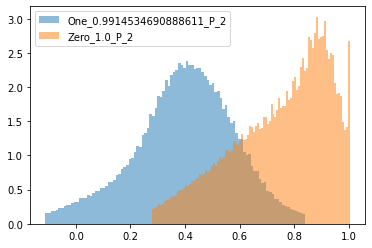

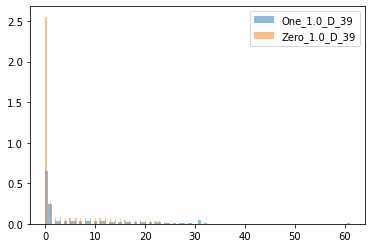

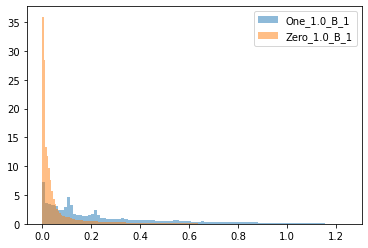

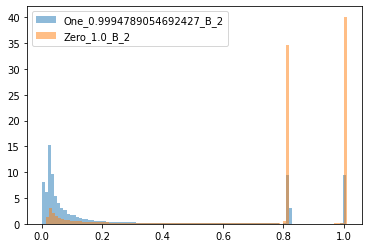

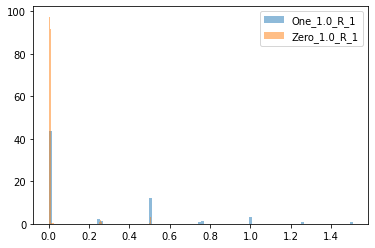

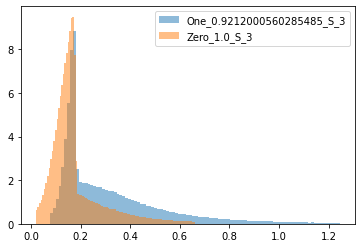

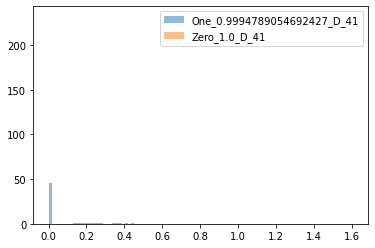

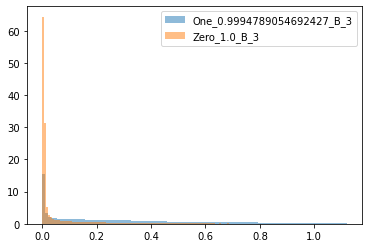

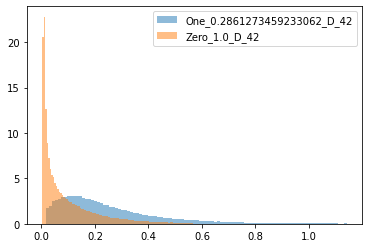

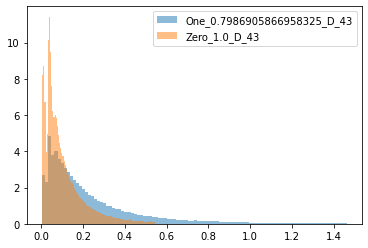

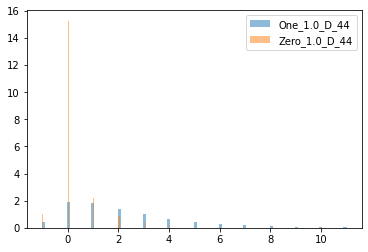

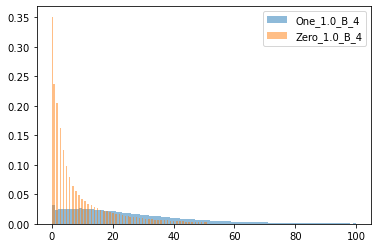

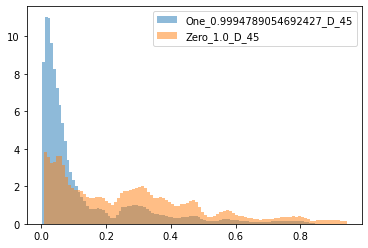

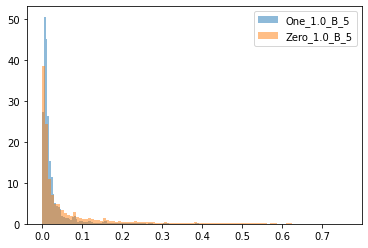

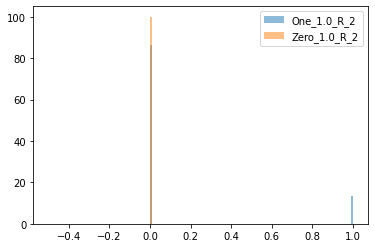

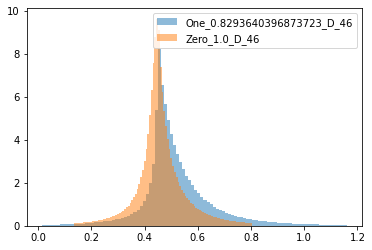

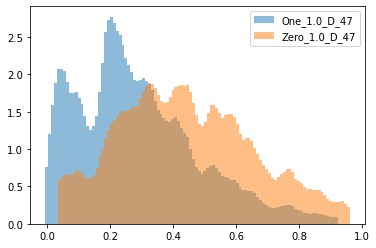

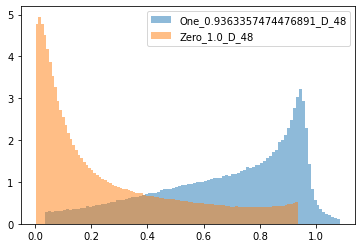

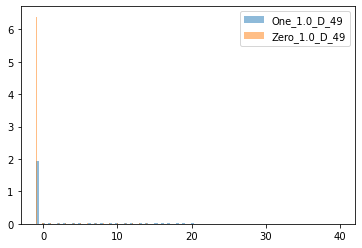

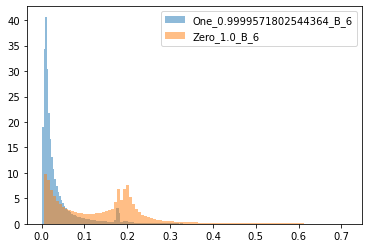

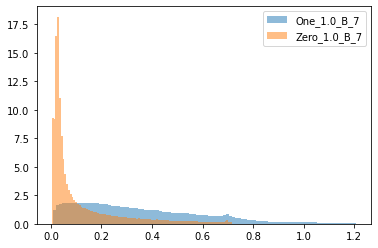

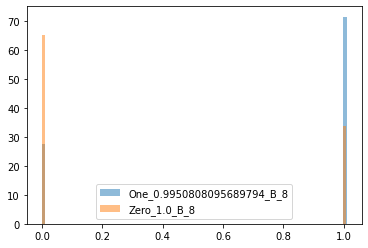

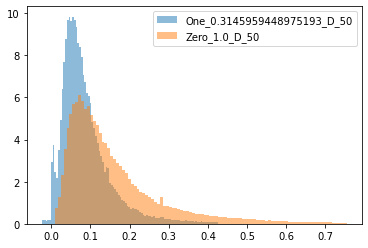

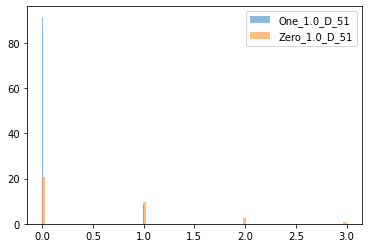

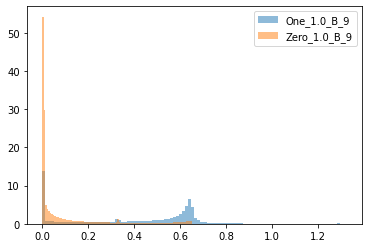

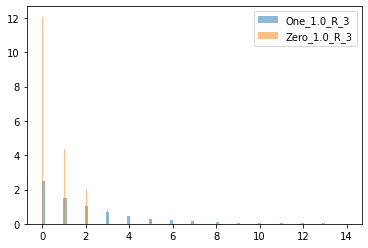

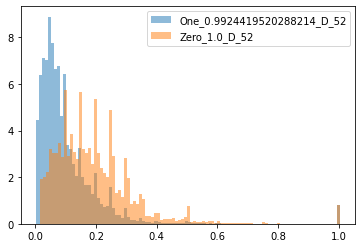

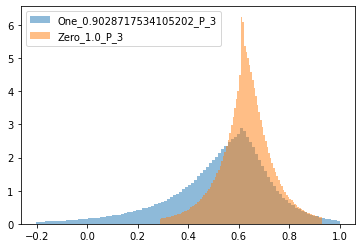

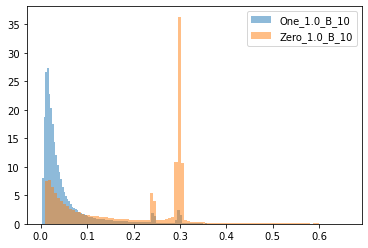

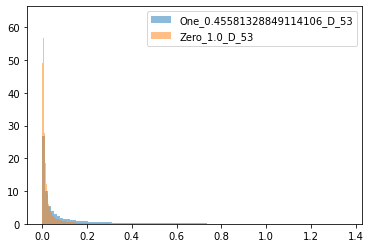

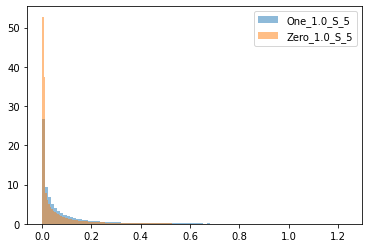

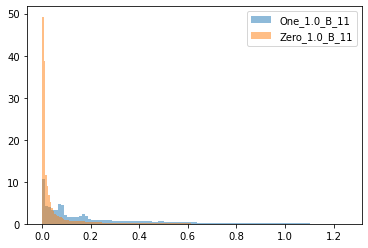

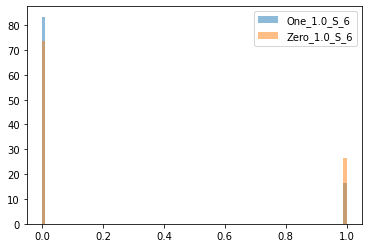

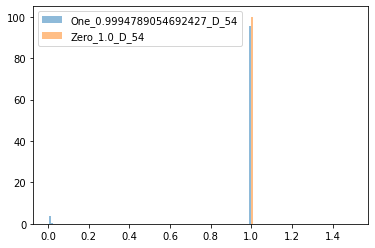

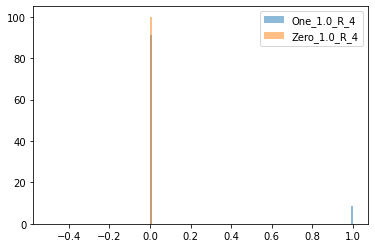

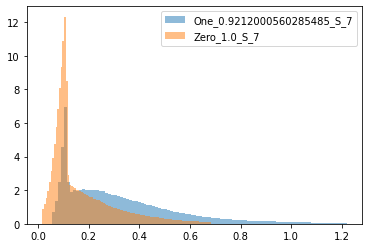

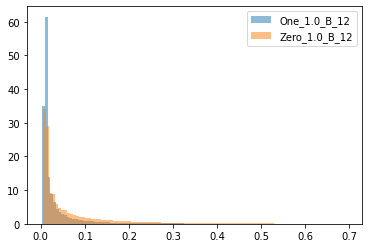

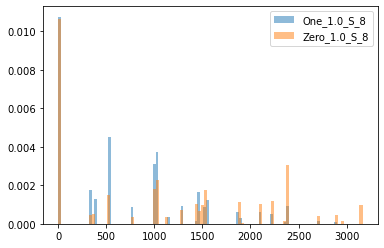

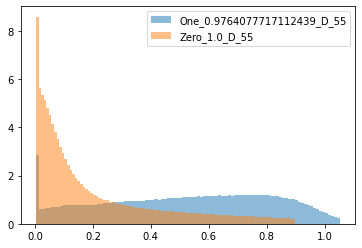

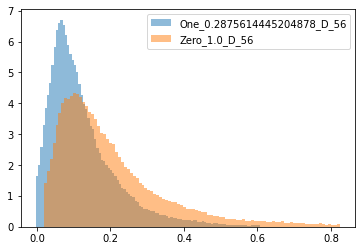

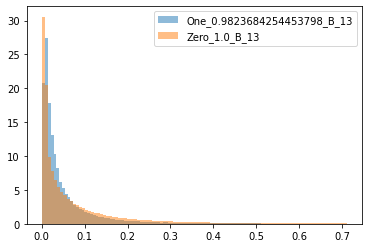

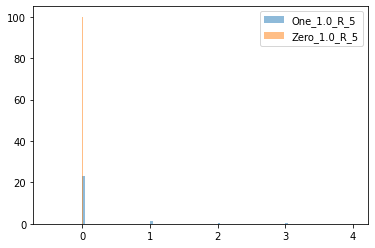

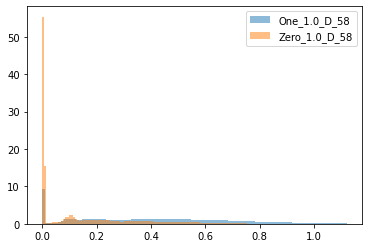

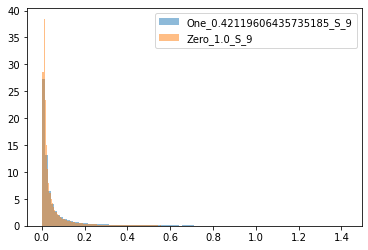

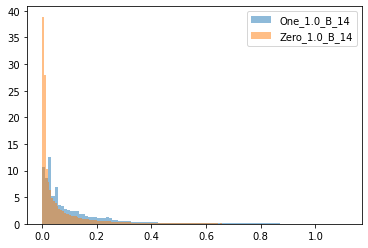

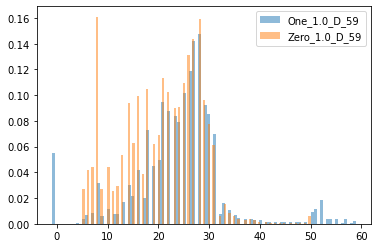

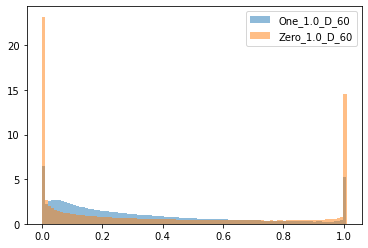

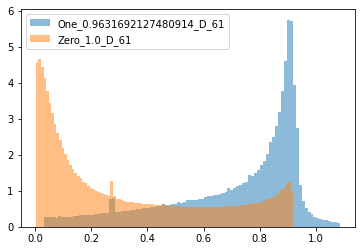

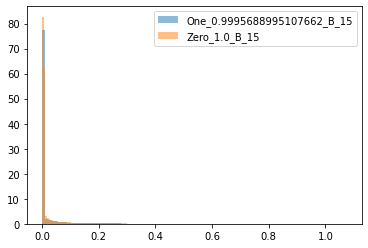

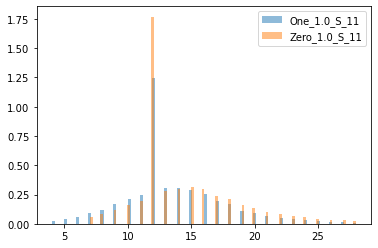

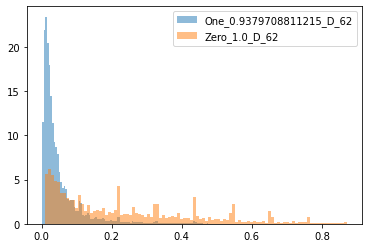

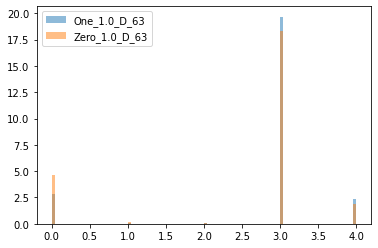

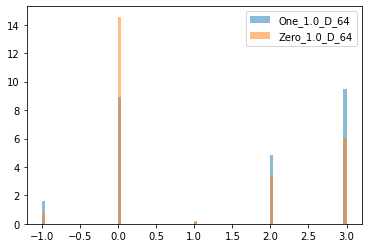

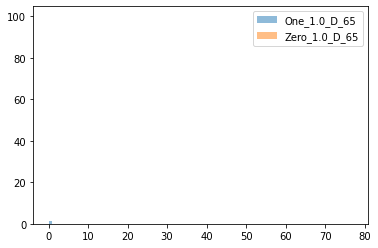

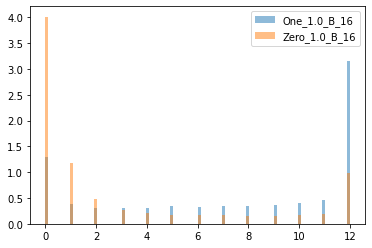

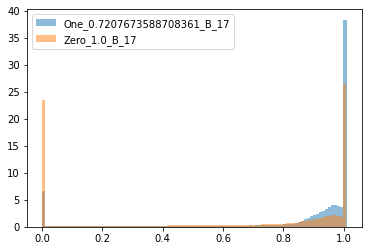

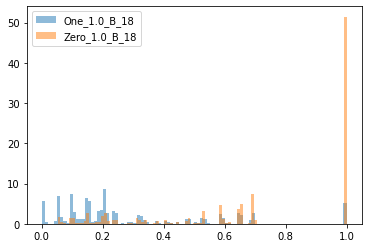

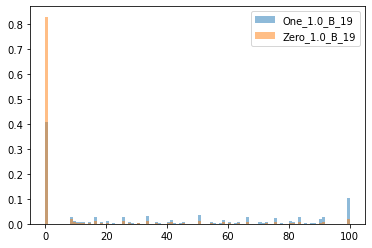

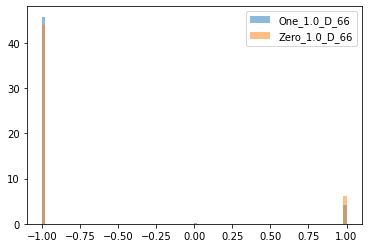

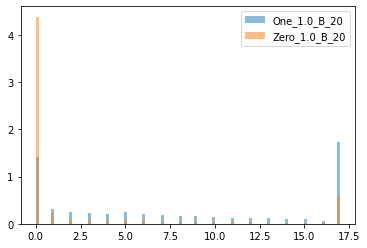

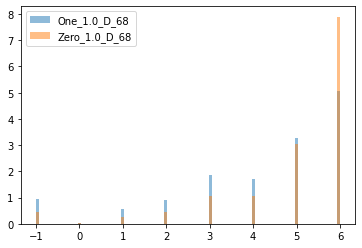

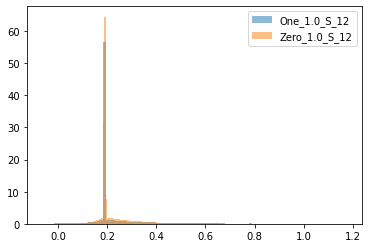

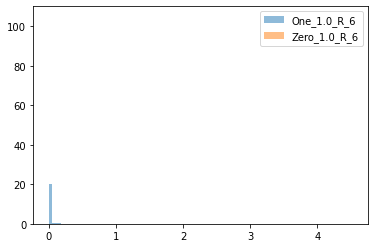

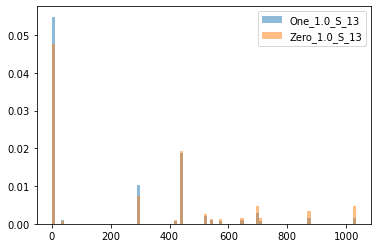

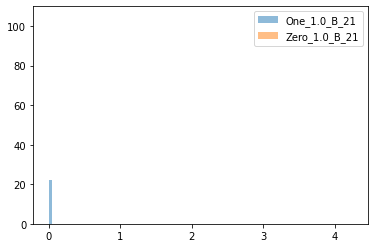

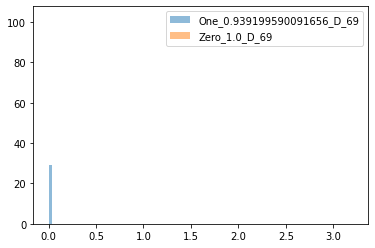

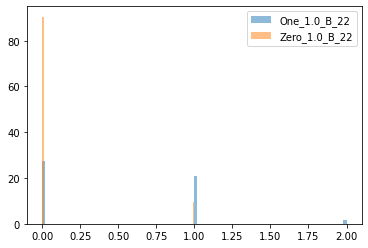

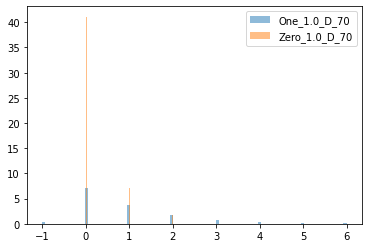

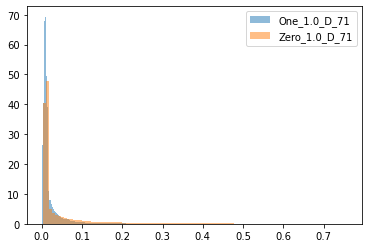

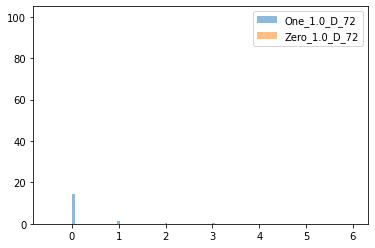

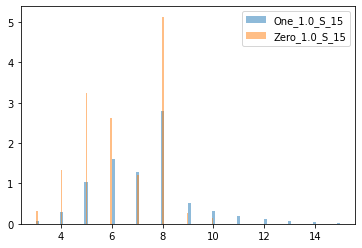

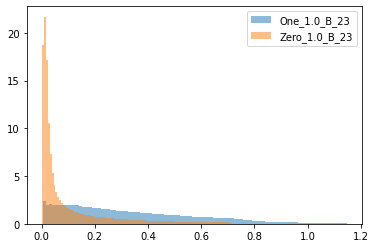

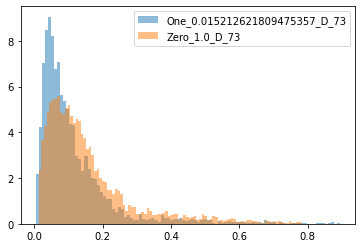

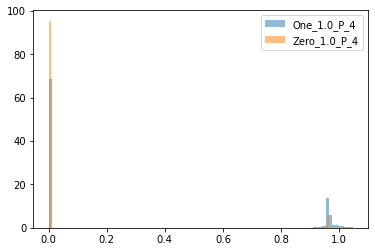

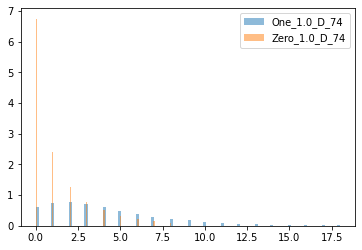

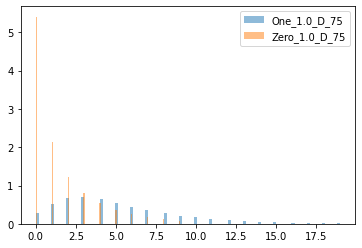

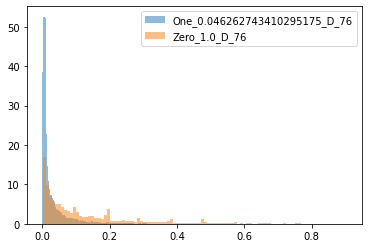

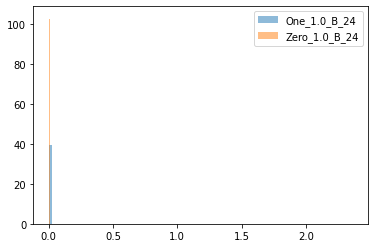

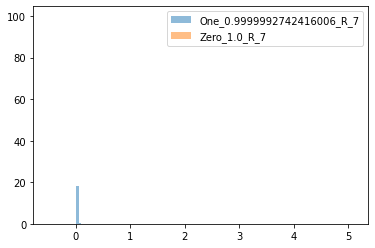

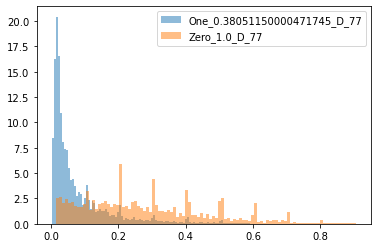

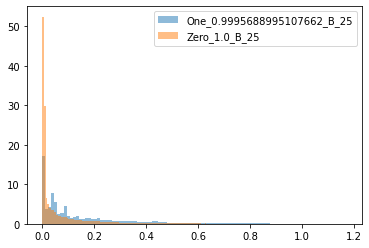

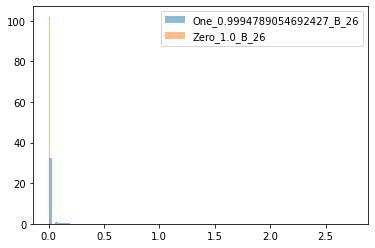

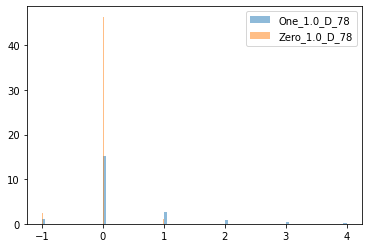

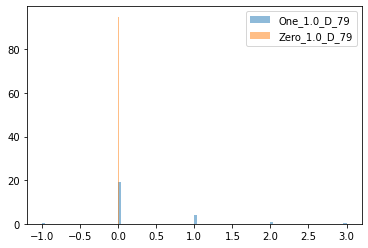

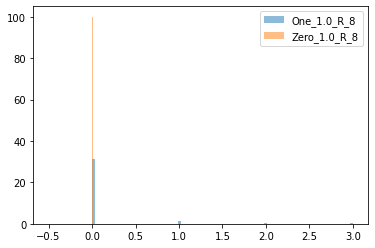

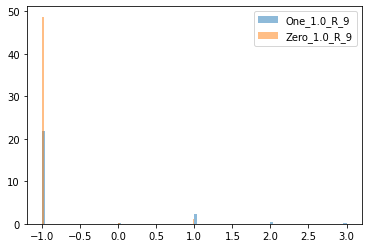

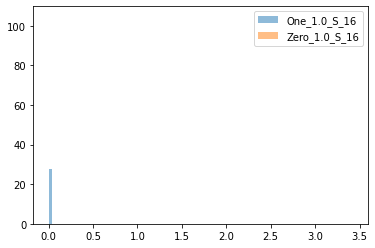

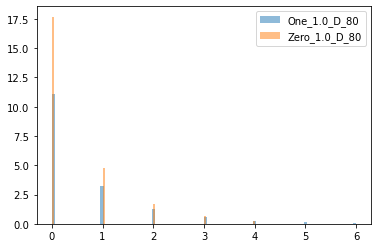

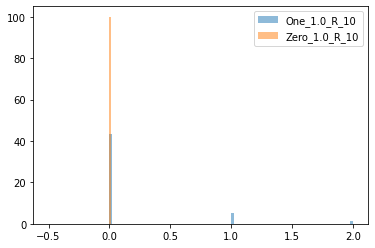

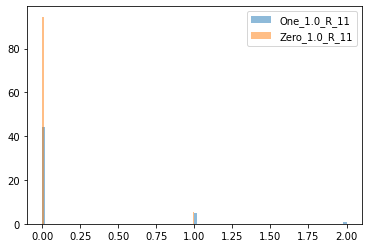

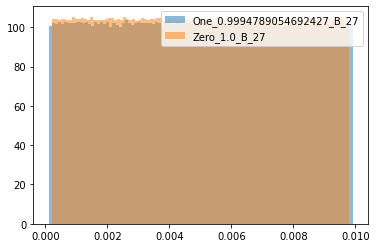

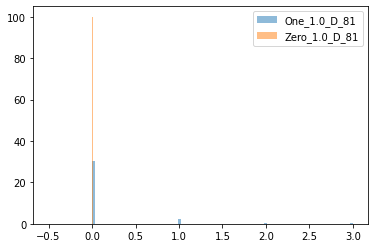

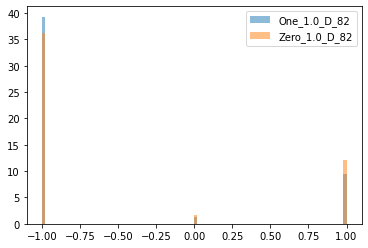

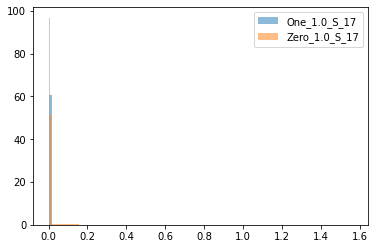

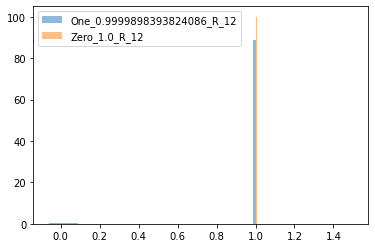

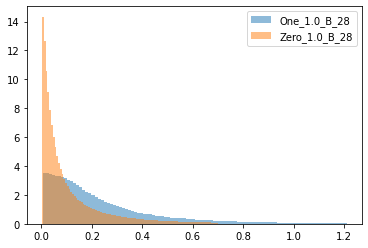

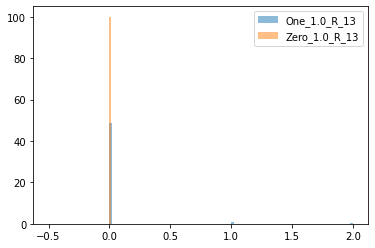

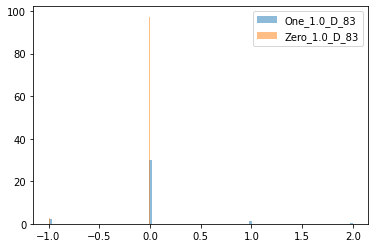

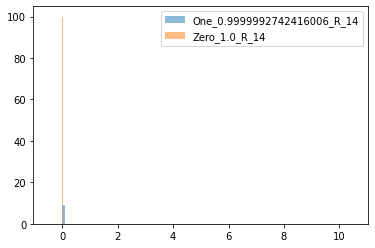

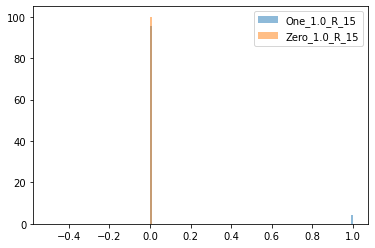

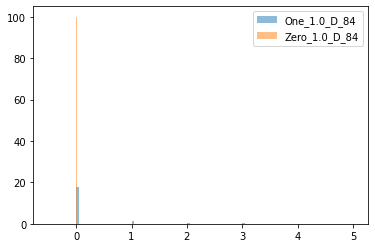

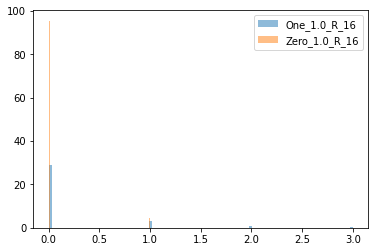

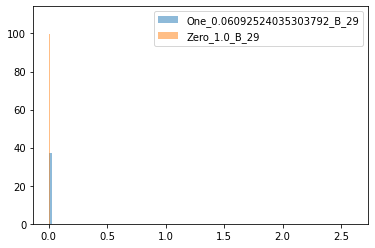

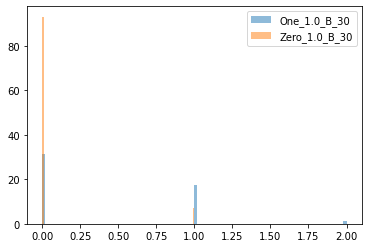

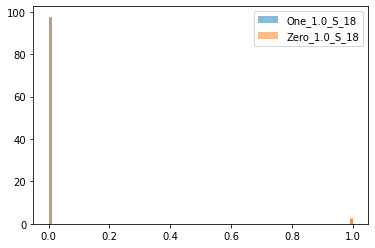

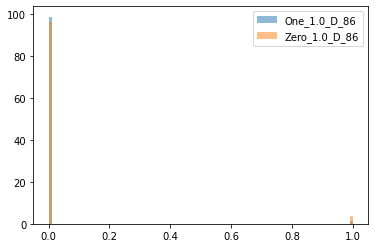

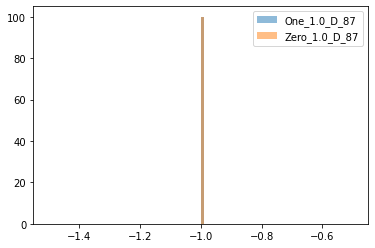

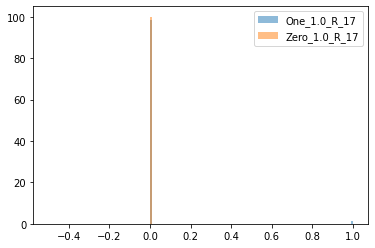

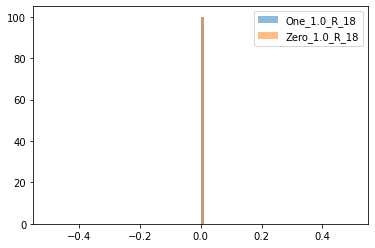

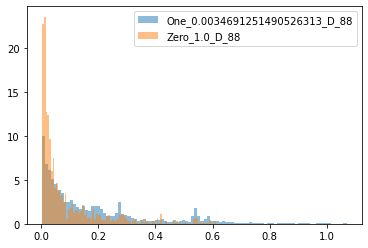

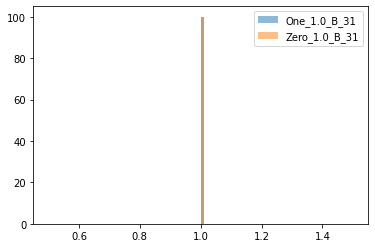

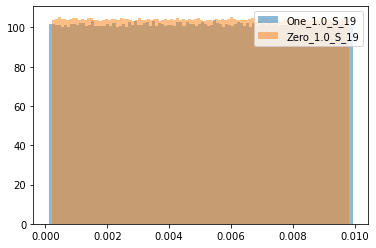

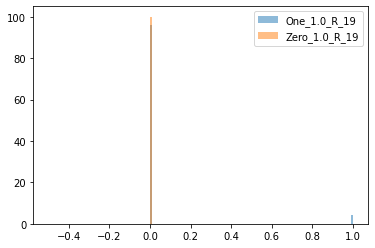

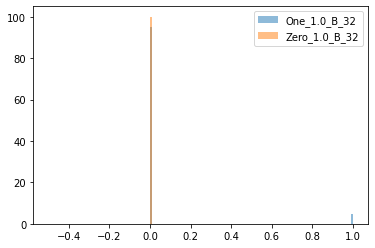

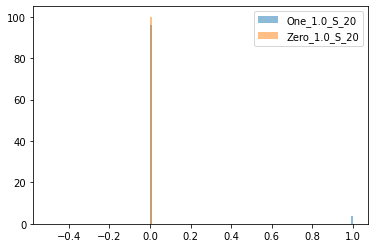

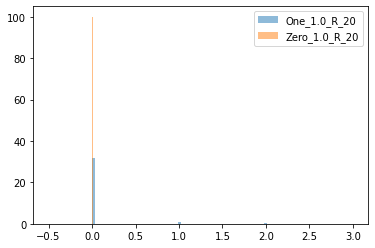

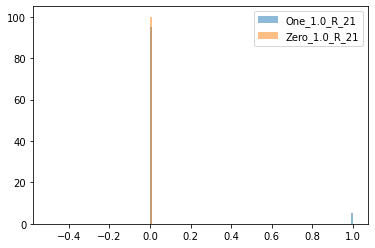

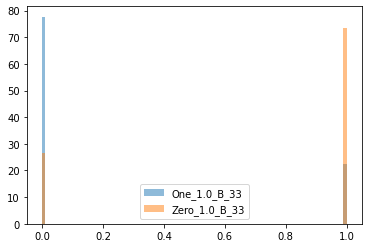

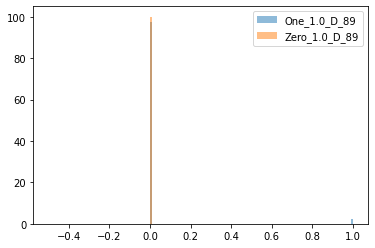

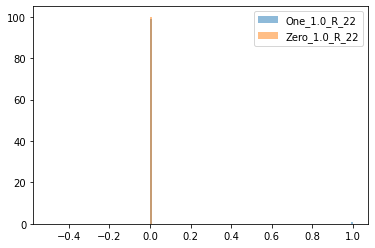

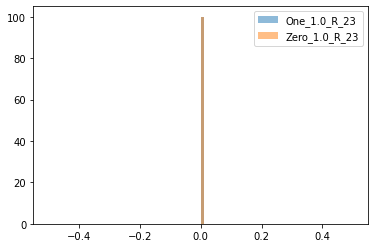

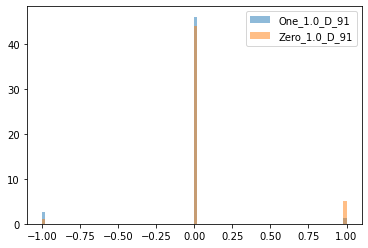

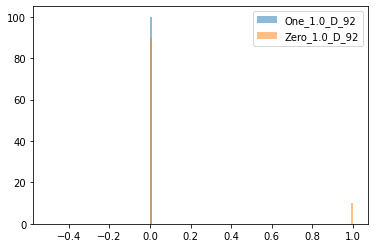

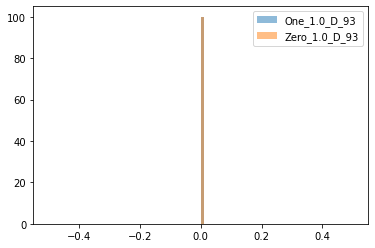

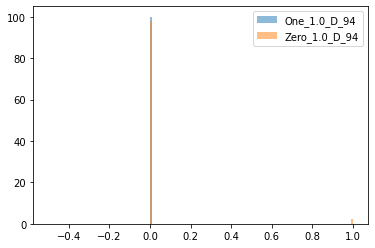

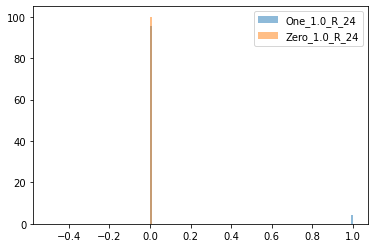

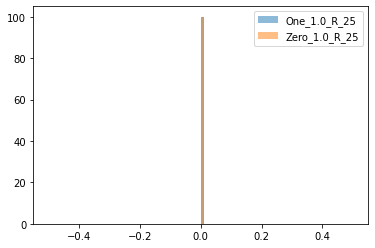

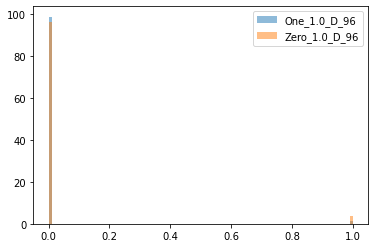

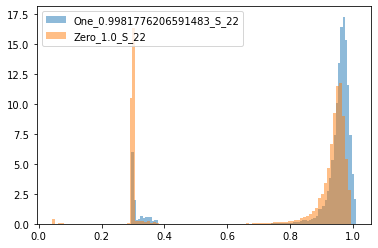

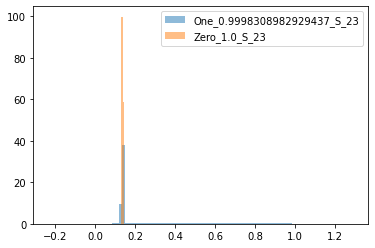

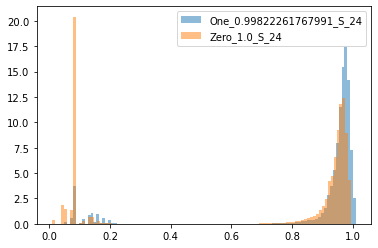

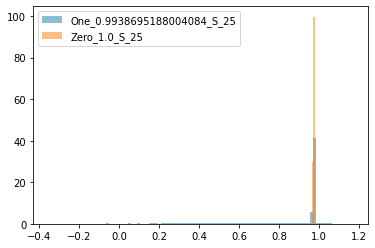

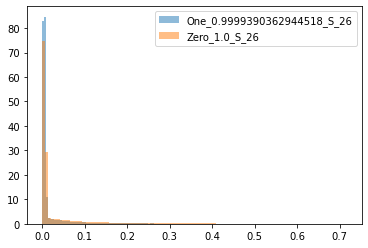

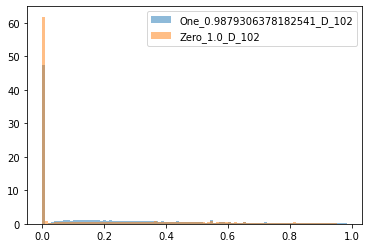

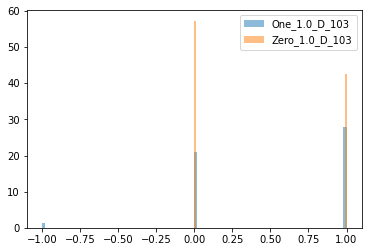

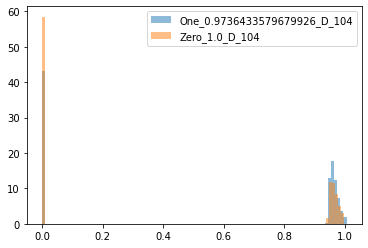

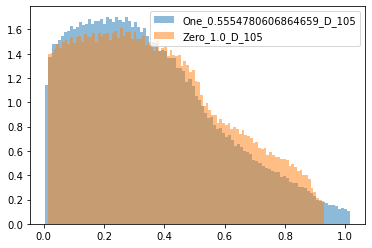

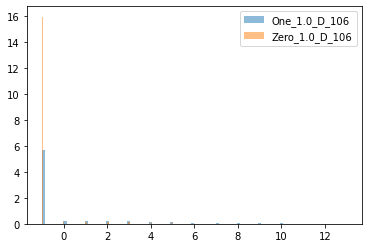

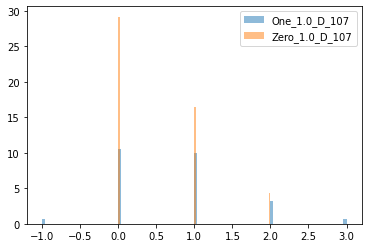

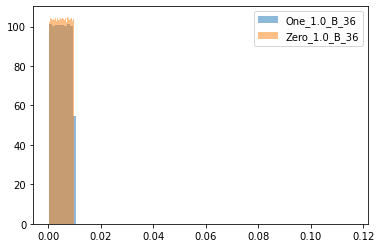

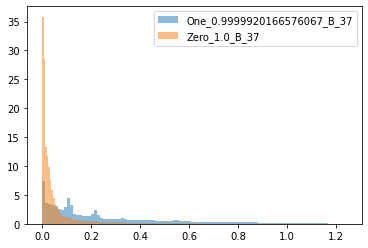

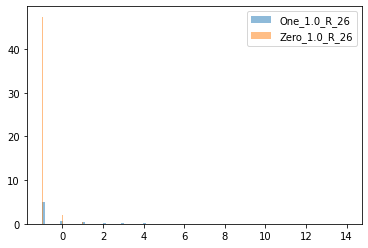

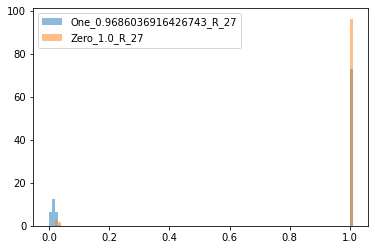

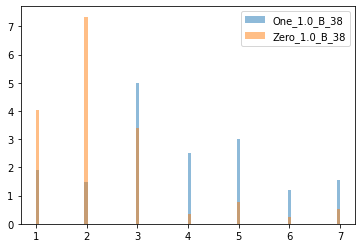

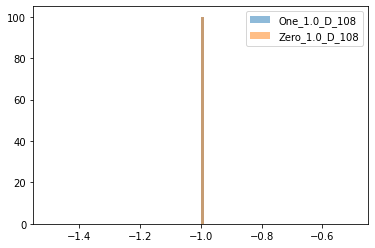

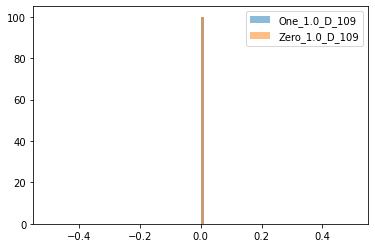

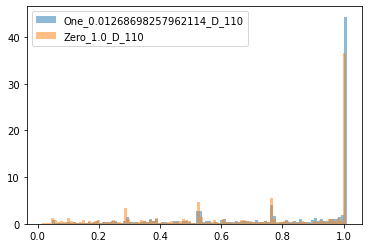

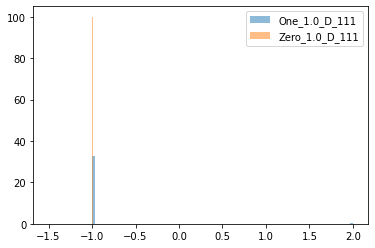

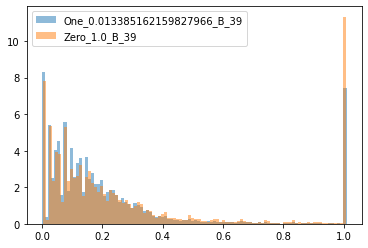

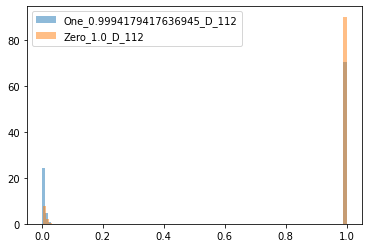

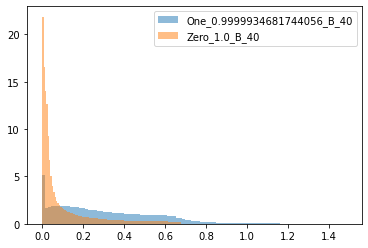

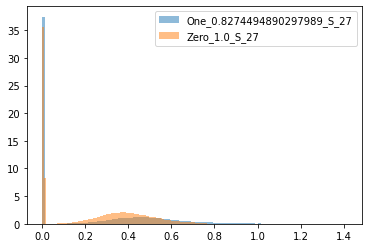

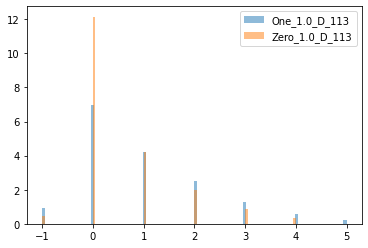

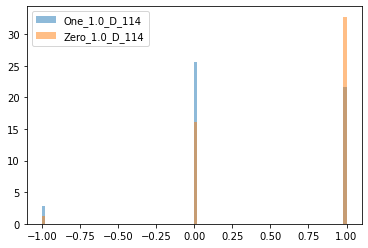

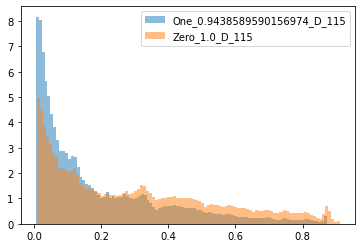

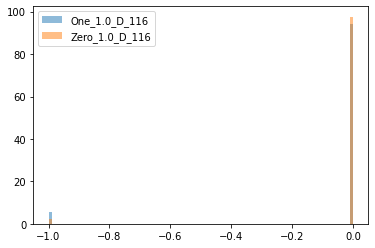

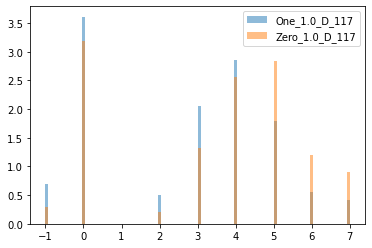

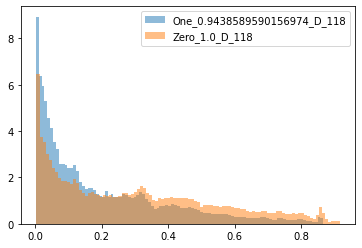

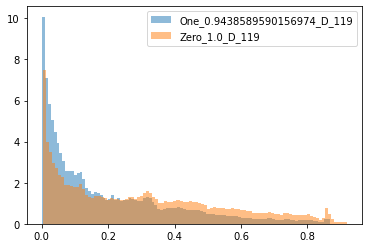

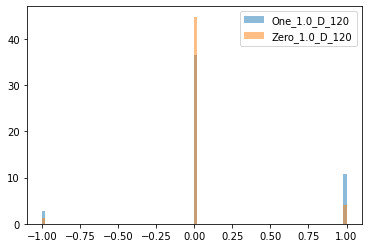

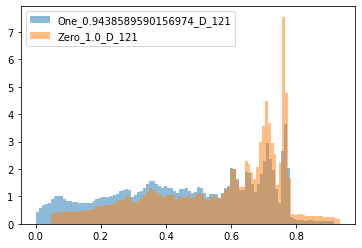

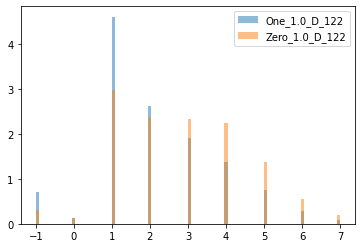

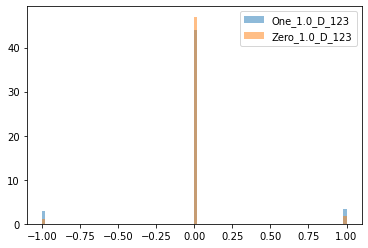

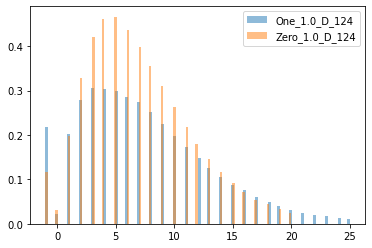

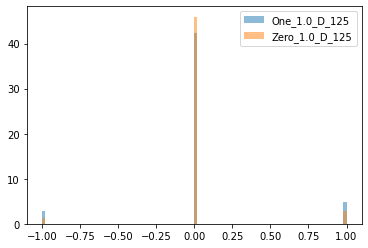

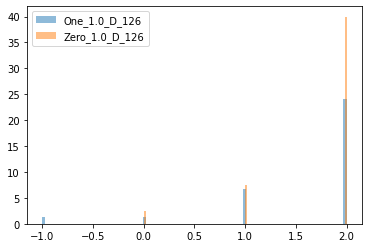

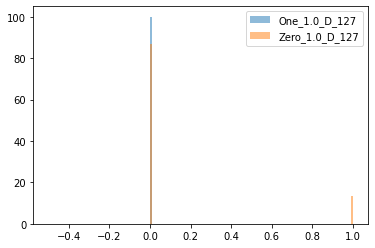

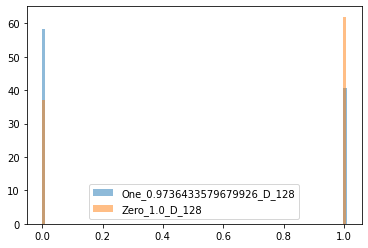

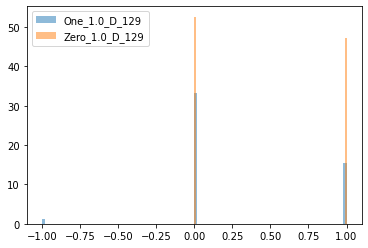

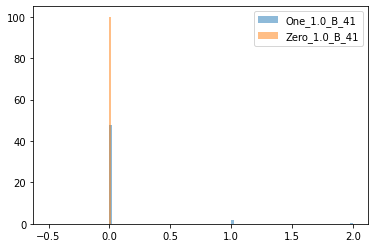

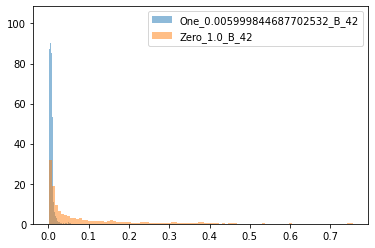

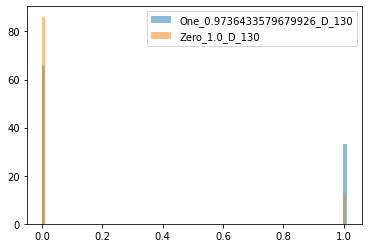

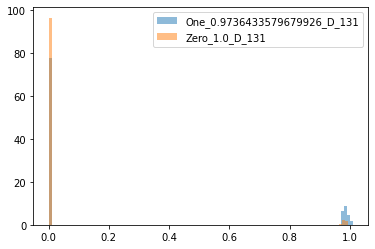

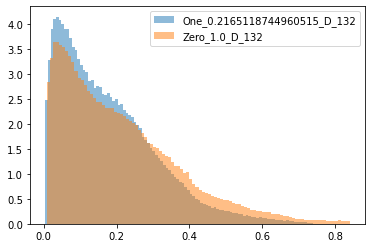

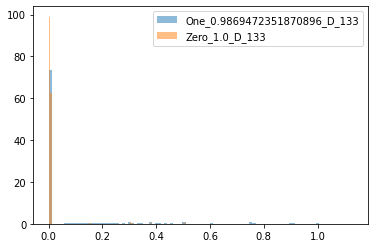

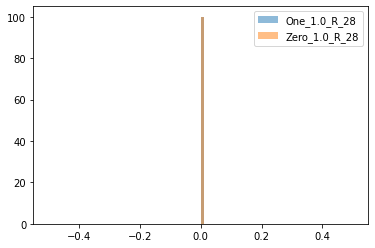

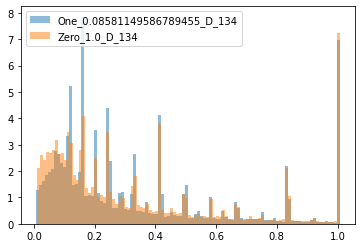

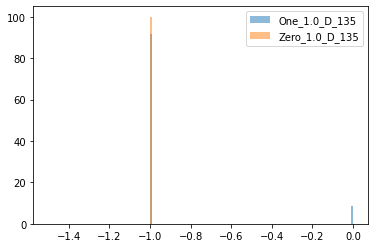

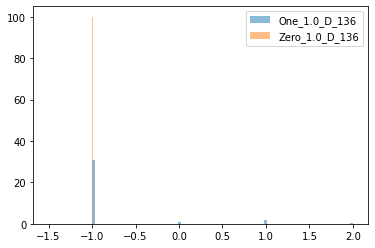

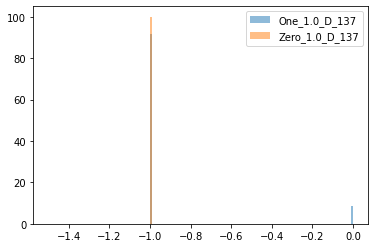

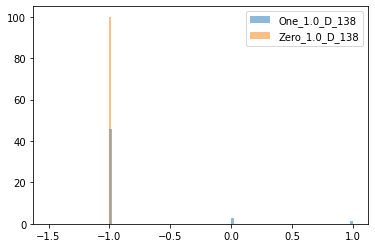

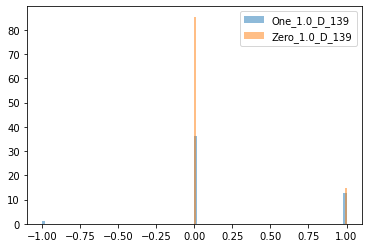

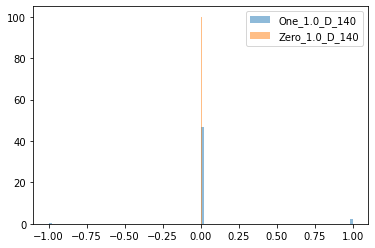

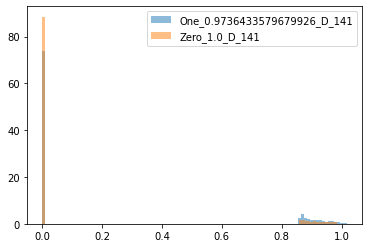

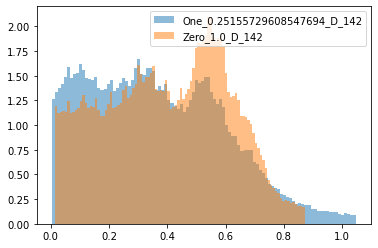

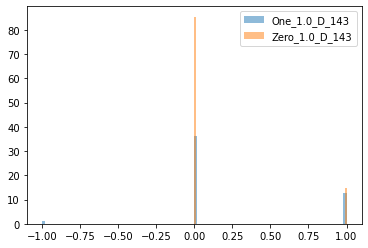

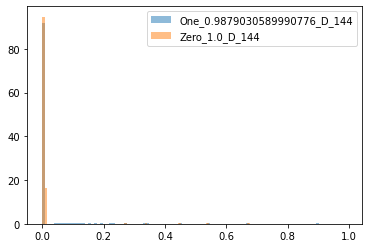

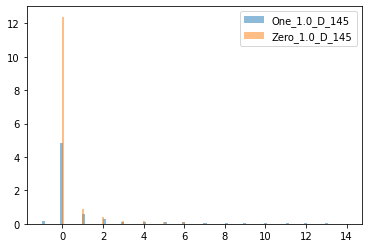

In [13]:
N0 = c0d.shape[0]
N1 = c1d.shape[0]

for c in train_data.columns:
    if  train_data.dtypes[c] != object:
        d = c1d[c].dropna()
        q1 = d.quantile(.01)
        q2 = d.quantile(.99)
        plt.hist(d, range=[q1, q2], bins=100, label=f"One_{d.shape[0]/N1}_{c}", density=True, alpha=0.5)
        d = c0d[c]
        q1 = d.quantile(.02)
        q2 = d.quantile(.98)
        plt.hist(d, range=[q1, q2], bins=100, label=f"Zero_{d.shape[0]/N0}_{c}", density=True, alpha=0.5)
        plt.legend()
        plt.show()


In [43]:
c1d[c].quantile(1)

1.009979

nan